Copyright (c) 2025 Qualcomm Technologies, Inc.
All Rights Reserved.

# Minimal example on how to run ACP-GN (Approximate full Conformal Prediction via Gauss-Newton influence)

The main scripts in this repository are geared towards reproducing the results in the paper, which requires a lot of overhead. In this notebook, we demonstrate how to run ACP-GN on regression tasks step by step and without that overhead.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data_utils
from torch.backends import cudnn

# Local imports
from lib.crr import eval_acp, eval_bayes, eval_crr, eval_jackknife
from lib.datasets_uci import RegressionDatasets
from lib.models import MLP
from lib.trainer import train_laplace_model
from lib.utils import to_numpy

%matplotlib inline

## Settings and Hyperparameters

We start by setting the necessary settings and hyperparameters.

In [2]:
# Settings
WIDTH = 50  # Number of hidden units in the layers of the neural regressor
DEPTH = 1  # Number of layers of the neural regressor
ACTIVATION = "gelu"  # Activation function of the neural regressor
HYPERPARAM_OPT = "marglik"  # Type of hyperparameter optimization
LR = 1e-2  # Learning rate
LR_CV = 1e-3  # Learning rate when using cross-validation
LR_MIN = 1e-5  # Minimum learning rate used by the scheduler
N_EPOCHS = 5000  # Number of epochs to train the model for
BATCH_SIZE = 256  # Batch size for training and evaluation
PRIOR_PREC_INIT = 1.0  # Initial prior precision
LR_HYP = 1e-2  # Learning rate used to update hyperparameters
LR_HYP_MIN = 1e-3  # Minimum learning rate the scheduler can set to update hyperparameters
N_EPOCHS_BURNIN = 100  # Number of epochs to train before estimating the marginal likelihood
MARGLIK_FREQUENCY = 50  # How often to estimate (and differentiate) the marginal likelihood
N_HYPERSTEPS = 50  # How many steps to take on the hyperparams when marginal likelihood is estimated
N_EPOCHS_CV = 1000  # Number of epochs to train for when fitting hyperparams via cross-validation
PRIOR_PREC_LOG_LOWER = -4  # Lowest value of log prior precision to consider.
PRIOR_PREC_LOG_UPPER = 4  # Highest value of log prior precision to consider.
CRR_ALGO = "burnaev"  # CRR implementation choice of "nouretdinov", "vovk", "vovk_mod", "burnaev"

# Set device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {DEVICE}.")
# Set random seed
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    cudnn.deterministic = True
    cudnn.benchmark = False

Running on cuda.


## Preparing the dataset and data loaders
We need four datasets.
- Train: Only used if running cross-validation to find the prior precision matrix (HYPERPARAM_OPT='CV').
- Validation: Also only used if running cross-validation (HYPERPARAM_OPT='CV').
- Train full: Simply Train and Validation sets put together. Used to train the model and run full conformal prediction.
- Test: Used only for testing.

In [3]:
# Setting up the data
DATASET = "yacht"

# 90%/10% train/test split same as [Hernandez-Lobato & Adams, 2015]
ds_kwargs = {
    "split_train_size": 0.9,
    "split_valid_size": 0.1,
    "split_calib_size": 0,
    "root": "../data/",
    "seed": SEED,
    "kfold_idx": -1,  # No k-fold
    "device": DEVICE,
}

# Construct datasets
# Training data split into training and validation datasets
ds_train = RegressionDatasets(DATASET, split="train", **ds_kwargs)
# Validation data (only used for hyperparameter fine tuning inside Laplace's optimization)
ds_valid = RegressionDatasets(DATASET, split="valid", **ds_kwargs)
# Full training dataset (same data as above, only not divided in two)
ds_train_full = RegressionDatasets(
    DATASET, split="train", **{**ds_kwargs, **{"split_valid_size": 0.0}}
)
# Test data
ds_test = RegressionDatasets(DATASET, split="test", **ds_kwargs)

# Construct dataloaders
train_loader = data_utils.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
train_loader_full = data_utils.DataLoader(ds_train_full, batch_size=BATCH_SIZE, shuffle=True)
data_loader_jacs = data_utils.DataLoader(ds_train_full, batch_size=BATCH_SIZE, shuffle=False)
calib_loader = None  # We don't need calibration data for full CP.
valid_loader = data_utils.DataLoader(ds_valid, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data_utils.DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

# Model training

Train the model and compute Laplace approximation. This leverages the Laplace package https://github.com/aleximmer/Laplace

This will give us the model $\theta^*$ that satisfies

$\theta_* = arg\,min_{\theta} \Big( \sum_{i=1}^N \ell(y_i, f_i(x_i ;\theta)) + \tfrac{1}{2} \delta \left\lVert \theta \right\rVert ^2 \Big)$

with $\ell$ a given loss function and $\{x_i, y_i\}^N$ is a training dataset of size $N$. The whole point of our method is to enable us to use the training data to pretrain the model in this way **and** run conformal prediction later on. Of course, this gives us only an approximation of the full conformal prediction method, but the approximation turns out to be quite reliable in most cases (see results in the paper).

In [4]:
# Define the model
input_size = ds_train_full.data.size(1)
model = MLP(input_size, WIDTH, DEPTH, output_size=1, activation=ACTIVATION).to(DEVICE)

In [5]:
la, la_bayes = train_laplace_model(
    HYPERPARAM_OPT,
    model,
    train_loader_full,
    train_loader,
    valid_loader,
    N_EPOCHS,
    N_EPOCHS_CV,
    LR,
    LR_CV,
    LR_MIN,
    LR_HYP,
    LR_HYP_MIN,
    N_EPOCHS_BURNIN,
    N_HYPERSTEPS,
    MARGLIK_FREQUENCY,
    PRIOR_PREC_INIT,
    PRIOR_PREC_LOG_LOWER,
    PRIOR_PREC_LOG_UPPER,
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


## ACP-GN without refinement

Here we essentially compute the $a_i$ and $b_i$ terms for each training point, and $a_{N+1}$ and $b_{N+1}$ which corresponds to a given test point (see equations (13) and (14)).

$y_i - f_i(\theta_*^+(y)) \approx \underbrace{y_i - f_i(\theta_*) + \frac{\hat{h}_{i,N+1}}{1+\hat{h}_{N+1}} f_{N+1}(\theta_*)}_{a_i} \underbrace{- \frac{\hat{h}_{i,N+1}}{1+\hat{h}_{N+1}}}_{b_i}$

$y - f_{N+1}(\theta_*^+(y)) \approx \underbrace{-\frac{1}{1+\hat{h}_{N+1}} f_{N+1}(\theta_*)}_{a_{N+1}} + \underbrace{\frac{1}{1+\hat{h}_{N+1}}}_{b_{N+1}} y$


We start by computing  $a_{N+1}$ and $b_{N+1}$. For each test point, we collect the prediction of the model (`preds_test` or $f_{N+1}(\theta_*)$), the leverages (`h_test` or $\hat{h}_{N+1}$) and the Jacobians (`js_test`), which will later be used to compute $\hat{h}_{i,N+1}$ (`h_test_train`).

In [6]:
# Evaluate quantities needed for CRR methods on the TEST data.
preds_test = []  # Model predictions
js_test = []  # Jacobians
h_test = []  # Leverages
for batch_x, batch_y in test_loader:
    # Evaluate "leverage" and predictions on test points
    js_batch, preds_batch = la.backend.jacobians(batch_x)
    preds_batch = preds_batch.squeeze()
    fvar = la.functional_variance(js_batch).squeeze()
    _, n_outs, n_params = js_batch.shape
    # and cache Jacs to compute cross-leverages later
    js_batch = js_batch.reshape(len(batch_x) * n_outs, n_params)
    preds_test.append(preds_batch)
    js_test.append(js_batch)
    h_test.append(fvar)
# Construct torch tensors
preds_test = torch.cat(preds_test)
js_test = torch.cat(js_test)
h_test = torch.cat(h_test)

We now do the same for each training point to compute $a_i$ and $b_i$. That is, for each training point we compute the prediction of the model (`preds_train` or $f_i(\theta_*)$) and the leverage (`h_test_train` or $\hat{h}_{i,N+1}$).

In [7]:
# Evaluate quantities needed for CRR methods on the TRAIN data.
preds_train = []  # Model predictions
js_train = []  # Jacobians
h_train = []  # Leverages on the training data
h_test_train = []  # Leverages on training and test data
for batch_x, batch_y in data_loader_jacs:
    # Leverage and predictions on train data
    js_batch, preds_batch = la.backend.jacobians(batch_x)
    preds_batch = preds_batch.squeeze()
    fvar = la.functional_variance(js_batch).squeeze()
    _, n_outs, n_params = js_batch.shape
    js_batch = js_batch.reshape(len(batch_x) * n_outs, n_params)
    js_train.append(js_batch)
    fvar_cross = torch.einsum(
        "mp,pq,nq->mn", js_test, la.posterior_covariance, js_batch
    )  # (M, batch_size)
    preds_train.append(preds_batch)
    h_train.append(fvar)
    h_test_train.append(fvar_cross)
preds_train = torch.cat(preds_train)
js_train = torch.cat(js_train)
h_train = torch.cat(h_train)
h_test_train = torch.cat(h_test_train, dim=-1)
targets_train = ds_train_full.targets

### Applying Conformal Ridge Regression (CRR)
Once these terms $a_i, b_i$ and $a_{N+1}, b_{N+1}$ are computed, we can apply any conformal ridge regression algorithm to get the prediction intervals.

Here we compare four methods in particular. See the paper for the details on each variant.
- Bayes (confidence intervals given by the approximate Bayes posterior predictive distribution)
- Standard CRR
- Studentized CRR
- Deleted CRR

Note that in the paper, unless explicitly mentioned otherwise, we report results of Studentized CRR, as we found this to work best among the CRR variants.

In [8]:
# Significance levels (alpha)
sig_lvls = [0.01, 0.05, 0.1]
intvl_kwargs = {
    "ys": to_numpy(targets_train.squeeze()),
    "preds": to_numpy(preds_train.squeeze()),
    "preds_eval": to_numpy(preds_test.squeeze()),
    "h_mn": to_numpy(h_test_train.squeeze()),
    "h_n": to_numpy(h_train.squeeze()),
    "sigma_sq": la.sigma_noise.item() ** 2,
    "sig_lvls": sig_lvls,
}
cp_intervals = []
for method in ["bayes", "crr_standard", "crr_studentized", "crr_deleted"]:
    method_parse = method.split("_")
    if method == "bayes":
        # Only use refined predictions for bayes when fitted using marglik.
        # Observed poor performance otherwise, hunch that caused by MLE fit of sigma_noise.
        fmu = to_numpy(preds_test.squeeze())
        cp_intervals += [
            eval_bayes(
                fmu=fmu,
                fvar=to_numpy(h_test.squeeze()),
                sigma_sq=la_bayes.sigma_noise.item() ** 2,
                sig_lvls=sig_lvls,
            )
        ]
    elif method_parse[0] == "crr":
        cp_intervals += [
            eval_crr(
                h_m=to_numpy(h_test.squeeze()),
                algo=CRR_ALGO,
                nonconformity_score=method_parse[1],
                **intvl_kwargs,
            )
        ]
    elif method_parse[0] == "jackknife":
        cp_intervals += [eval_jackknife(method=method_parse[1], **intvl_kwargs)]
    elif method == "acp":
        cp_intervals += [eval_acp(h_m=to_numpy(h_test.squeeze()), **intvl_kwargs)]
    else:
        raise ValueError("Invalid method")

### Correcting for normalization during pre-processing of the dataset
As usual for regression tasks, we normalize the data before fitting the neural network. Thus, we must rescale the prediction intervals to match the original output space of the model.

In [9]:
# Scaling used to preprocess the data (see RegressionDatasets in datasets_uci.py)
scale = ds_train_full.s
cp_intervals = np.array(cp_intervals)  # (n_methods, len(sig_lvls), n_test, 2)
# Mean PI width adjusted by targets standardization from data-preprocessing step.
interval_widths_avg = np.mean(
    scale * (cp_intervals[:, :, :, 1] - cp_intervals[:, :, :, 0]), axis=-1
)  # (n_methods, len(sig_lvls))

# Coverage.
y_test_np = ds_test.targets.squeeze().cpu().numpy()
y_test_np = y_test_np.reshape((1, 1, -1))
coverage = np.mean(
    (y_test_np >= cp_intervals[:, :, :, 0]) & (y_test_np <= cp_intervals[:, :, :, 1]),
    axis=-1,
)

### Plotting the results

Text(0.5, 1.0, 'Observed Coverage')

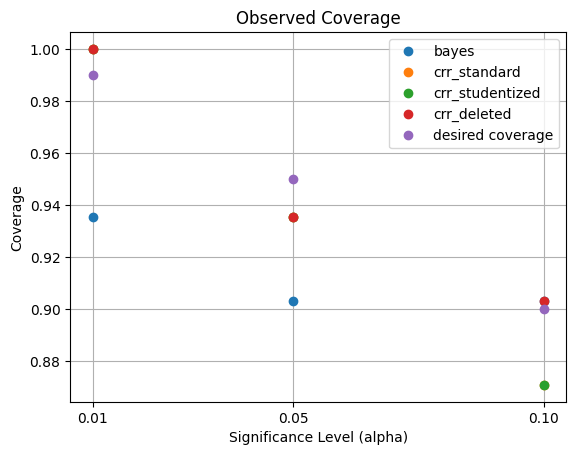

In [10]:
for i, method in enumerate(["bayes", "crr_standard", "crr_studentized", "crr_deleted"]):
    plt.plot(sig_lvls, coverage[i, ...], "o", label=method)
plt.plot(sig_lvls, 1 - np.asarray(sig_lvls), "o", label="desired coverage")
plt.legend()
plt.grid()
plt.xticks(np.asarray(sig_lvls))
plt.xlabel("Significance Level (alpha)")
plt.ylabel("Coverage")
plt.title("Observed Coverage")

Text(0.5, 1.0, 'Average Prediction Set Size')

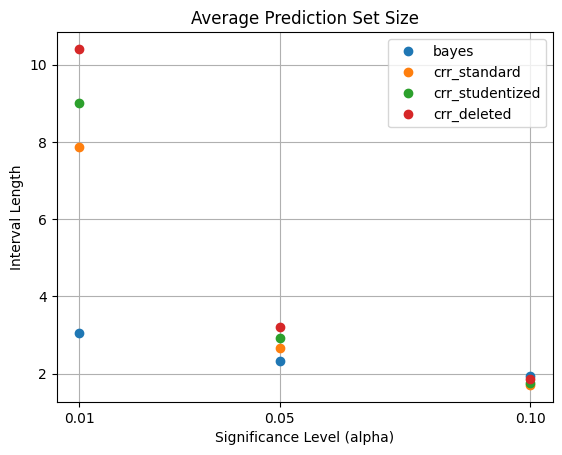

In [11]:
for i, method in enumerate(["bayes", "crr_standard", "crr_studentized", "crr_deleted"]):
    plt.plot(sig_lvls, interval_widths_avg[i, ...], "o", label=method)
plt.legend()
plt.grid()
plt.xticks(np.asarray(sig_lvls))
plt.xlabel("Significance Level (alpha)")
plt.ylabel("Interval Length")
plt.title("Average Prediction Set Size")